In [1]:
# Library imports

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product

from PIL import Image
import os
import random

2025-03-11 13:26:06.330878: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 13:26:06.339771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741699566.348890   26034 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741699566.351455   26034 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 13:26:06.360760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

TensorFlow Version: 2.18.0
Is TensorFlow built with CUDA? True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


I0000 00:00:1741699568.470151   26034 gpu_device.cc:2022] Created device /device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# Load the dataset

dataset = pd.read_csv('rare_species 1/metadata.csv')

# Display the first few rows and columns of the dataset

print("Dataset shape:", dataset.shape)
print("Dataset columns:", dataset.columns)

# EOL means Encyclopedia of Life

Dataset shape: (11983, 7)
Dataset columns: Index(['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'phylum',
       'family', 'file_path'],
      dtype='object')


Displaying image: rare_species 1/chordata_balaenicipitidae/28276513_1049385_eol-full-size-copy.jpg


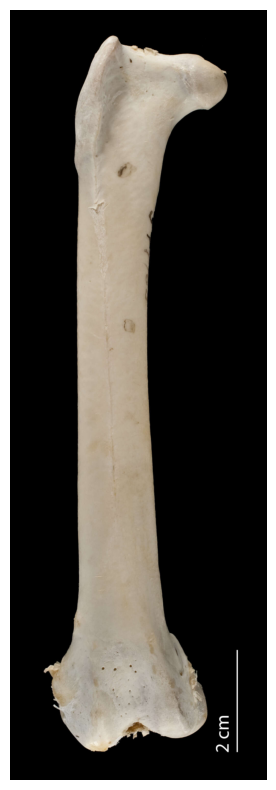

In [21]:
# Path to the folder
image_folder = 'rare_species 1/'

# List all images in the folder
image_files = []
for root, _, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_files.append(os.path.join(root, file))

# Show example function
def show_image(image_path: str) -> None:
    """
    Displays an image given its path.
    """
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # Remove axis for cleaner visualization
    plt.show()

# Show an example
if image_files:
    print(f"Displaying image: {image_files[0]}")
    show_image(image_files[0])
else:
    print("No images found in the folder.")

In [5]:
# Selecting the features and the target variable

X = dataset.iloc[:, 1:5].values  # Select features, excluding 'rare_species_id'
file_paths = dataset['file_path'].values.reshape(-1, 1)  # Reshape to column vector for concatenation
y = dataset.iloc[:, 5].values  # 'family' column as the target

# Concatenate file paths as an additional column
X = np.concatenate((X, file_paths), axis=1)

In [6]:
# Display the first few rows of the features and target variable
print("Features (X):", X[:5])
print("Target (y):", y[:5])

Features (X): [[12853737 449393 'animalia' 'mollusca'
  'mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg']
 [20969394 793083 'animalia' 'chordata'
  'chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg']
 [28895411 319982 'animalia' 'chordata'
  'chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg']
 [29658536 45510188 'animalia' 'chordata'
  'chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg']
 [21252576 7250886 'animalia' 'chordata'
  'chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg']]
Target (y): ['unionidae' 'geoemydidae' 'cryptobranchidae' 'turdidae' 'indriidae']


In [7]:
# Check the unique values of the columns,
# seeing which can be one-hot encoded

#print(dataset['rare_species_id'].unique())
print("eol_content_id unique values:", dataset['eol_content_id'].nunique())
print("eol_page_id unique values:", dataset['eol_page_id'].nunique())
print("kingdom unique values:", dataset['kingdom'].nunique())
print("phylum unique values:", dataset['phylum'].nunique())

print("file_path unique values:", dataset['file_path'].nunique())

print("family unique values:", dataset['family'].nunique())

eol_content_id unique values: 11983
eol_page_id unique values: 400
kingdom unique values: 1
phylum unique values: 5
file_path unique values: 11983
family unique values: 202


In [8]:
# Display 'phylum' unique values
print("phylum unique values:", dataset['phylum'].unique())

phylum unique values: ['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']


In [9]:
# Display 'kingdom' unique values
print("kingdom unique values:", dataset['kingdom'].unique())

# Do we really need the 'kingdom' column?

kingdom unique values: ['animalia']


In [20]:
# Transforming categorical data into numerical data
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(drop="first"), [3])],  # Only select the 'phylum' column
    remainder='passthrough'
)

X = np.array(ct.fit_transform(X))

# Display the transformed feature set
print(X[:5])

[[0.0 0.0 1.0 0.0 12853737 449393 'animalia'
  'mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg']
 [0.0 0.0 0.0 1.0 20969394 793083 'animalia'
  'chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg']
 [0.0 0.0 0.0 1.0 28895411 319982 'animalia'
  'chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg']
 [0.0 0.0 0.0 1.0 29658536 45510188 'animalia'
  'chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg']
 [0.0 0.0 0.0 1.0 21252576 7250886 'animalia'
  'chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg']]


Displaying sample train images:


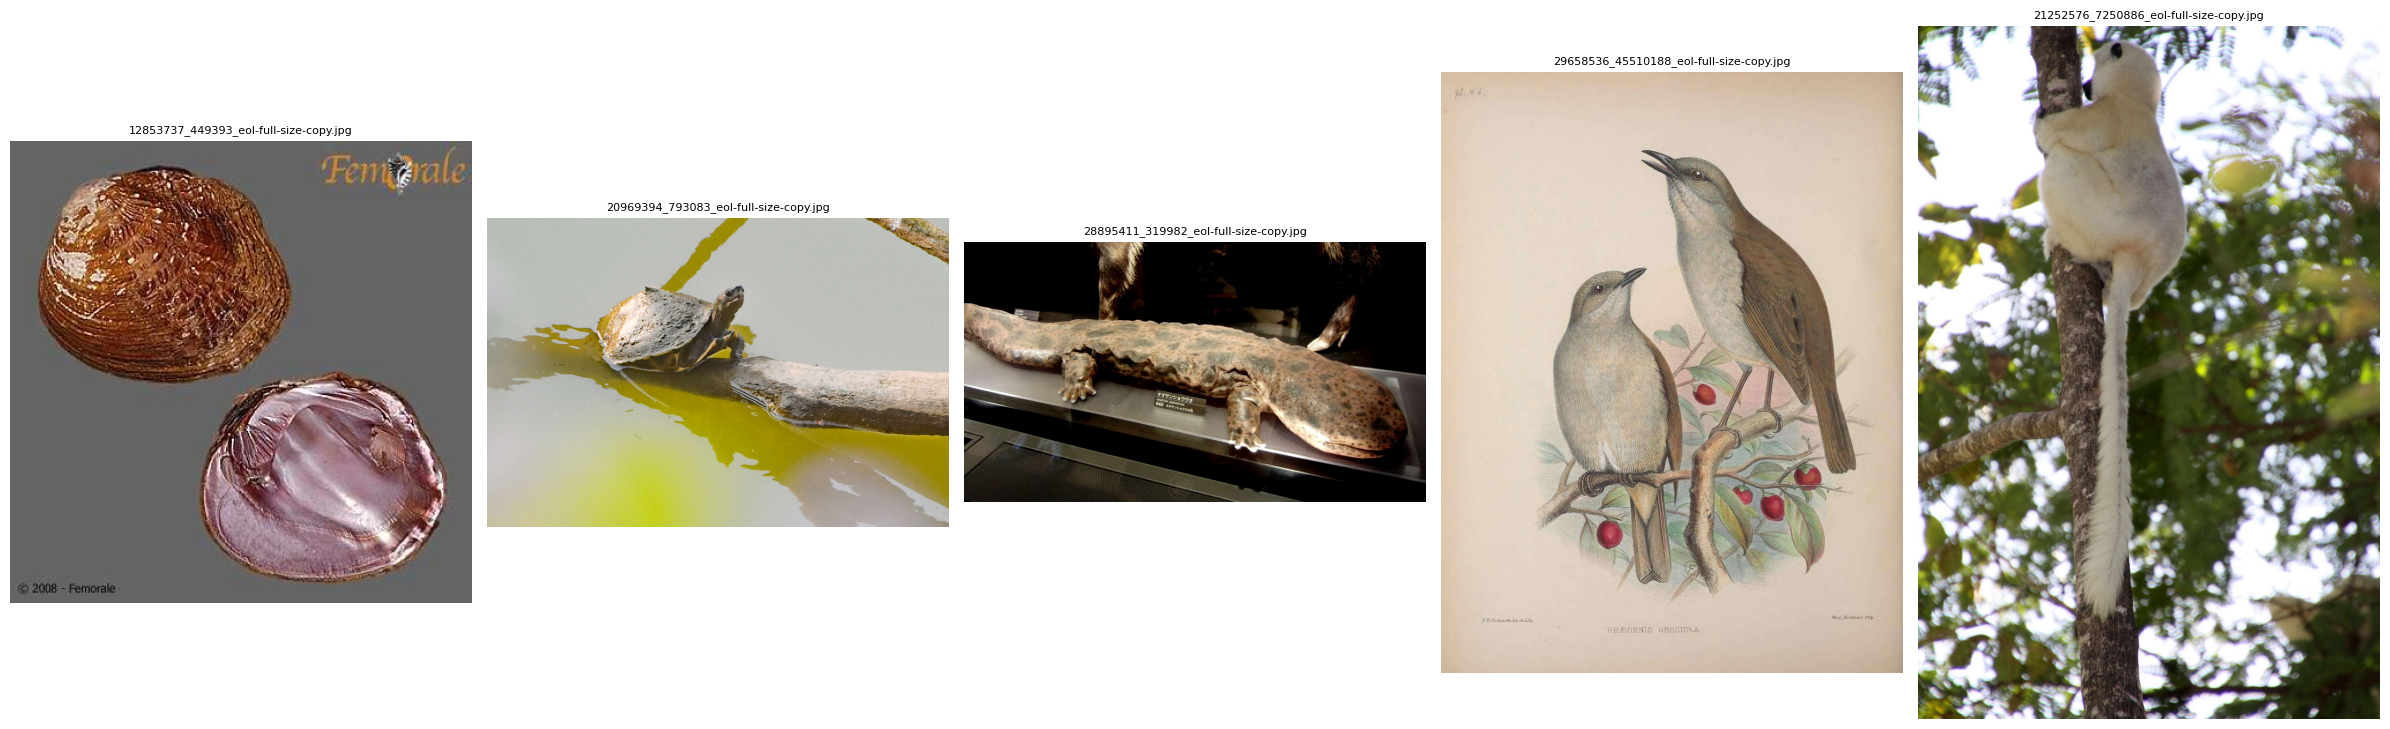

In [17]:
# Display sample images with file names
def show_images(images, n=5):
    plt.figure(figsize=(24, 12))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        image = Image.open(os.path.join(image_folder, images[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title(os.path.basename(images[i]), fontsize=8)  # Display filename as title
    plt.tight_layout()
    plt.show()

print("Displaying sample train images:")
show_images(X[:, -1], n=5)